In [1]:
from pathlib import Path
from os import listdir
from os.path import isfile, join
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Obtain Data

In [2]:
root_dir = Path(os.getcwd())
feature_path = root_dir/'feature_database'
text_path = root_dir/'short_text_database'

In [3]:
word = 'down'
# sample = '0a2b400e_nohash_3.csv'

In [4]:
feature_samples = [root_dir/'feature_database'/word/f for f in listdir(feature_path/word) if isfile(join(feature_path/word, f)) and f.endswith('.csv')]
text_samples = [root_dir/'short_text_database'/word/f for f in listdir(text_path/word) if isfile(join(text_path/word, f)) and f.endswith('.csv')]

# Formant Feature Extraction

In [5]:
def get_formant_features(feature_sample_path):
    db = pd.read_csv(feature_sample_path)
    
    # Only Take sounding portion from Voice Activity Recognition
    sound_db = db[db[' phoneme']=='sounding'].replace(to_replace='--undefined--', value=0)
    sound_db[' F1'] = pd.to_numeric(sound_db[' F1'], downcast='float')
    sound_db[' F2'] = pd.to_numeric(sound_db[' F2'], downcast='float')
    sound_db[' F3'] = pd.to_numeric(sound_db[' F3'], downcast='float')
    
    # Extract raw features in Hz of the sounding portion
    f1_og = sound_db[' F1'].to_numpy(dtype='float')
    f2_og = sound_db[' F2'].to_numpy(dtype='float')
    f3_og = sound_db[' F3'].to_numpy(dtype='float')
    
    return f1_og, f2_og, f3_og

In [6]:
def plot_formant_features(f1_og, f2_og, f3_og, ax=plt):
    ax.plot(f1_og, label = 'F1')
    ax.plot(f2_og, label = 'F2')
    ax.plot(f3_og, label = 'F3')

    ax.legend()
    if (ax == plt):
        ax.show()

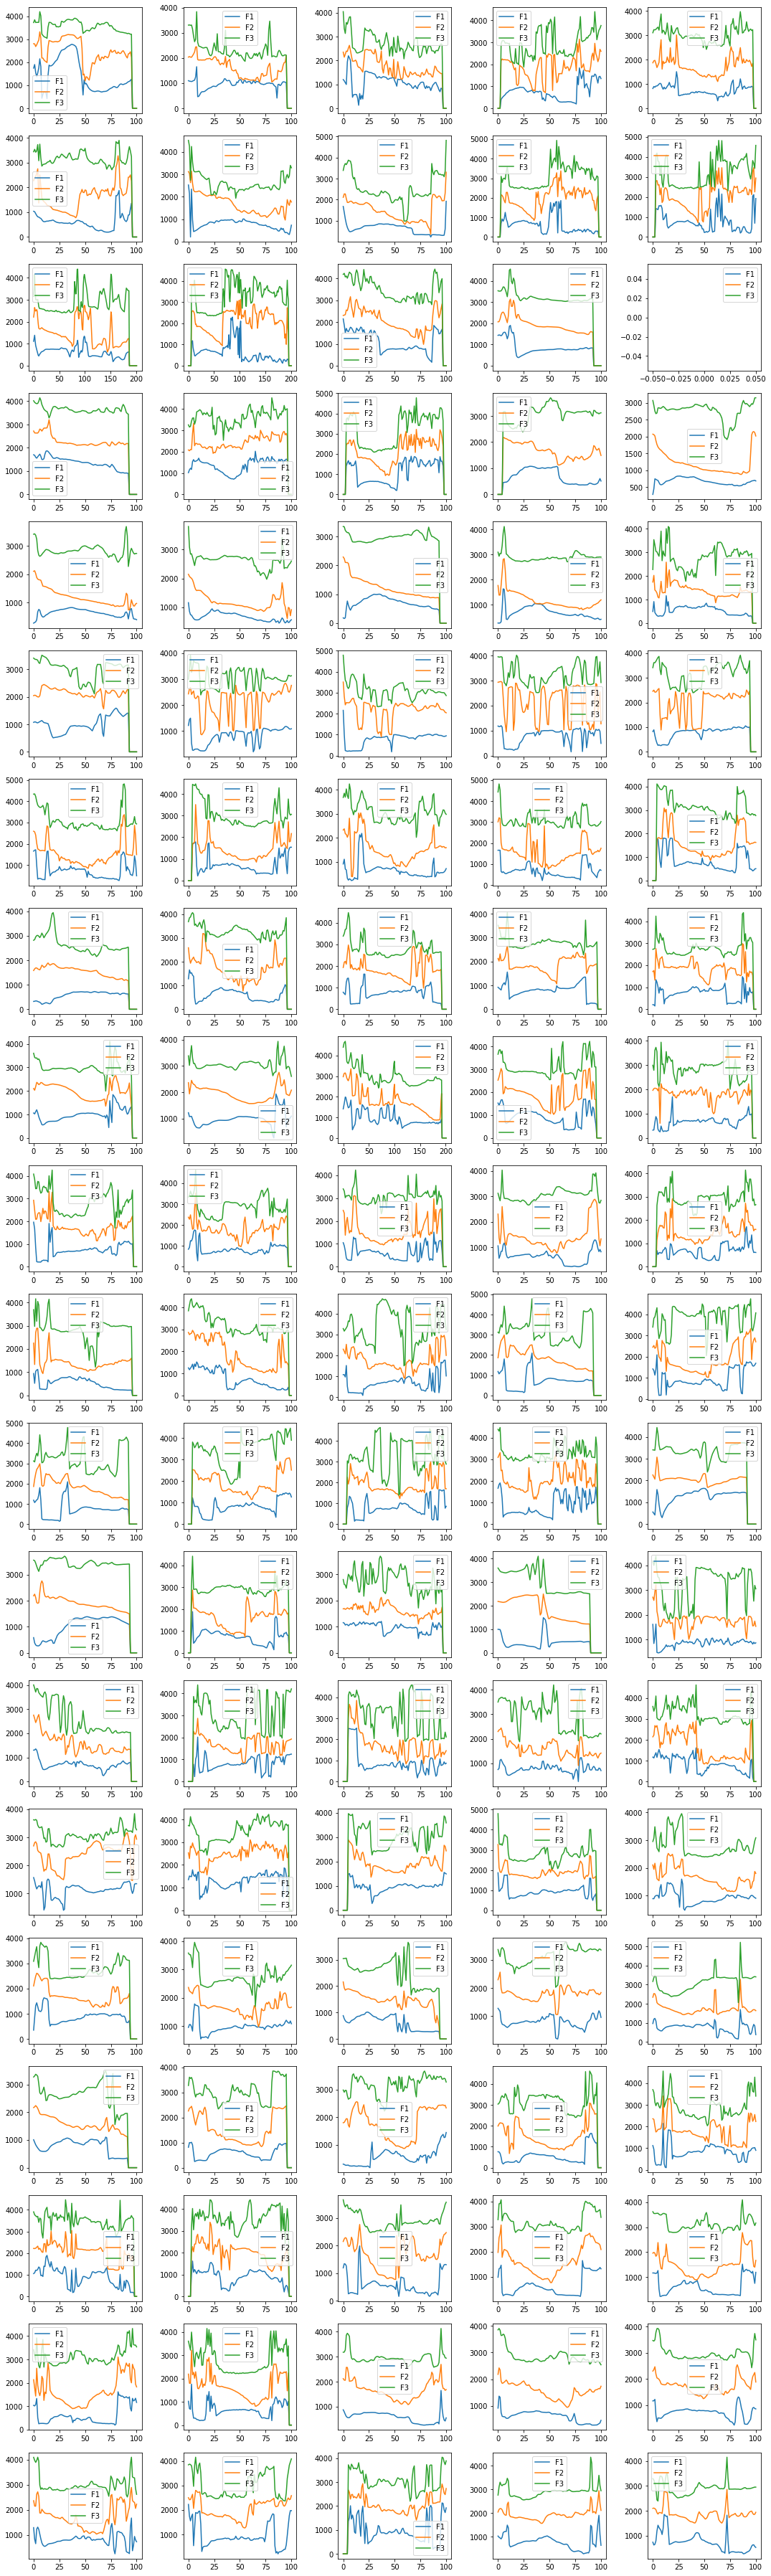

In [7]:
nrows=20
ncols=5
figure, ax = plt.subplots(nrows, ncols, figsize=(15,50))

for i in range(nrows):
    for j in range(ncols):
        f1_og, f2_og, f3_og = get_formant_features(feature_samples[i*ncols + j])
        plot_formant_features(f1_og, f2_og, f3_og, ax[i,j])

figure.tight_layout()

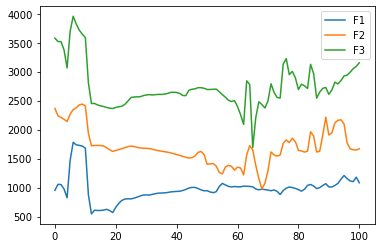

In [8]:
f1_og, f2_og, f3_og = get_formant_features(feature_samples[76])
plot_formant_features(f1_og, f2_og, f3_og)

## TODO:
- Feature formant ideas:
    - Difference between formants
    - Formant values themselves (look at if they slope up or down?)
    - Only look at the "voiced" sections

# Spectrogram Feature Extraction

In [9]:
def get_spectrogram(text_sample_path):
    stdb = pd.read_csv(text_sample_path)

    stdb = stdb.rename(columns={'File type = "ooTextFile"': 'val'})
    stdb_data = stdb.iloc[11:,:]

    nx = int(stdb.iloc[8]['val'])
    ny = int(stdb.iloc[3]['val'])

    new_spectrogram = np.array([[0]*ny]*nx, dtype='float')
    for x in range(nx):
        new_spectrogram[x] = stdb_data.iloc[x*ny:x*ny+ny].squeeze().to_numpy(dtype='float')

    # Adding minuscule quantity to spectrogram to avoid log(0)
    new_spectrogram += 0.0000000001
        
    log_new_spectrogram = np.log(new_spectrogram)
    return new_spectrogram, log_new_spectrogram

In [10]:
new_spectrogram, log_new_spectrogram = get_spectrogram(text_samples[15])
new_spectrogram.shape

(192, 991)

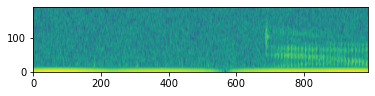

In [11]:
plt.imshow(log_new_spectrogram, origin='lower')

In [12]:
def get_plot_amplitude(log_new_spectrogram, ax=plt, plot=True):
    amplitude = np.sum(log_new_spectrogram, axis=0)
    
    if (plot==True):
        ax.plot(amplitude)

        if (ax==plt):
            ax.show()
        
    return amplitude

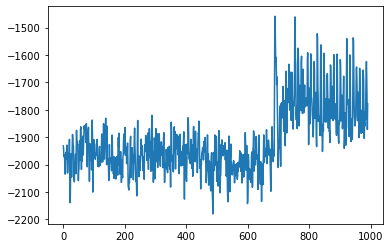

In [13]:
amplitude = get_plot_amplitude(log_new_spectrogram)

In [14]:
def get_plot_range_amplitudes(new_spectrogram, ax=plt, plot=True):
    # 192 - 6000 Hz
    # 96 - 3000 Hz Lower threshold for [s] sounds
    # 16 - 500 Hz There will likely always be something at the fundamental, so we can remove that if needed

    f_fund_limit = 16
    f_low = 96
    f_high = 192

    # Here make sure to add (np.sum), THEN do np.log on the result. 
    # Logging everything first then adding results in less accurate data.
    fund_range_spectrogram = new_spectrogram[0:f_fund_limit]
    low_range_spectrogram = new_spectrogram[f_fund_limit:f_low]
    high_range_spectrogram = new_spectrogram[f_low:f_high]
    fund_range_amplitude = np.log(np.sum(fund_range_spectrogram, axis=0))
    low_range_amplitude = np.log(np.sum(low_range_spectrogram, axis=0))
    high_range_amplitude = np.log(np.sum(high_range_spectrogram, axis=0))

    if (plot==True):
        ax.plot(fund_range_amplitude, label='fund range amplitude')
        ax.plot(low_range_amplitude, label='low range amplitude')
        ax.plot(high_range_amplitude, label='high range amplitude')

        ax.legend()
        if (ax==plt):
            ax.show()
        
    return fund_range_amplitude, low_range_amplitude, high_range_amplitude

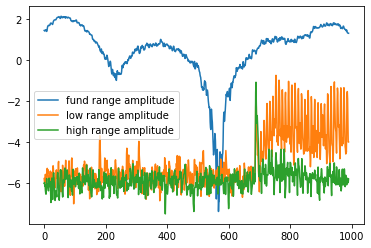

In [15]:
fund_range_amplitude, low_range_amplitude, high_range_amplitude = get_plot_range_amplitudes(new_spectrogram)

In [16]:
def get_plot_voicing(new_spectrogram, ax=plt, plot=True):
    # 160 - 5000 Hz
    # 3 - 90 Hz
    # 25 - 800 Hz

    f_fund_low = 3
    f_fund_high = 25
    num_harmonics = 5

    volume_offset_spectrogram = log_new_spectrogram[0:num_harmonics*f_fund_high]
    volume_offset_amplitude = (1/(num_harmonics*f_fund_high+1)) * np.sum(volume_offset_spectrogram, axis=0)

    voicing_amplitude = np.array([0]*log_new_spectrogram[0].shape[0], dtype='float64')
    f_fund = 0
    for f in range(f_fund_low, f_fund_high):
        test_voicing_amplitude = np.array([0]*log_new_spectrogram[0].shape[0], dtype='float64')
        for i in range(1, num_harmonics+1):
            test_voicing_amplitude += (log_new_spectrogram[i*f]) # This is what the paper did, but maybe isn't good (log_new_spectrogram[i*f] - volume_offset_amplitude)
        # Normalize
        max_val = np.quantile(test_voicing_amplitude, 1)
        min_val = np.quantile(test_voicing_amplitude, 0)
        test_voicing_amplitude = (test_voicing_amplitude - min_val) / (max_val - min_val)
        # Find f that gives the greatest magnitude
        curr_sum = np.sum(test_voicing_amplitude)
        if (curr_sum > np.sum(voicing_amplitude)):
            voicing_amplitude = test_voicing_amplitude
            f_fund = f
            
    if (plot==True):
        ax.plot(voicing_amplitude, label='Voicing Amplitude at F_0 = {f}'.format(f=f_fund))

        ax.legend()
        if (ax==plt):
            ax.show()

    return voicing_amplitude

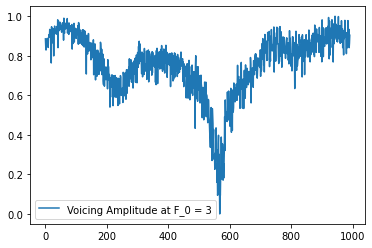

In [17]:
voicing_amplitude = get_plot_voicing(new_spectrogram)

In [22]:
def smooth_plot_voicing(voicing_amplitude, window, ax=plt, plot=True):
    smooth_voicing_amplitude = np.convolve(voicing_amplitude, np.ones(window), 'valid') / window
    
    if (plot==True):
        ax.plot(smooth_voicing_amplitude, label='Smooth Voicing')
        
        ax.legend()
        if (ax==plt):
            ax.show()

    return smooth_voicing_amplitude

In [18]:
def discretize_plot_voicing(voicing_amplitude, threshold, ax=plt, plot=True):
    discrete_voicing = np.where(voicing_amplitude > threshold, 1, 0) # threshold between 0-1. Usually 0.7
    
    if (plot==True):
        ax.plot(discrete_voicing, label='Discrete Voicing')
        
        ax.legend()
        if (ax==plt):
            ax.show()

    return discrete_voicing

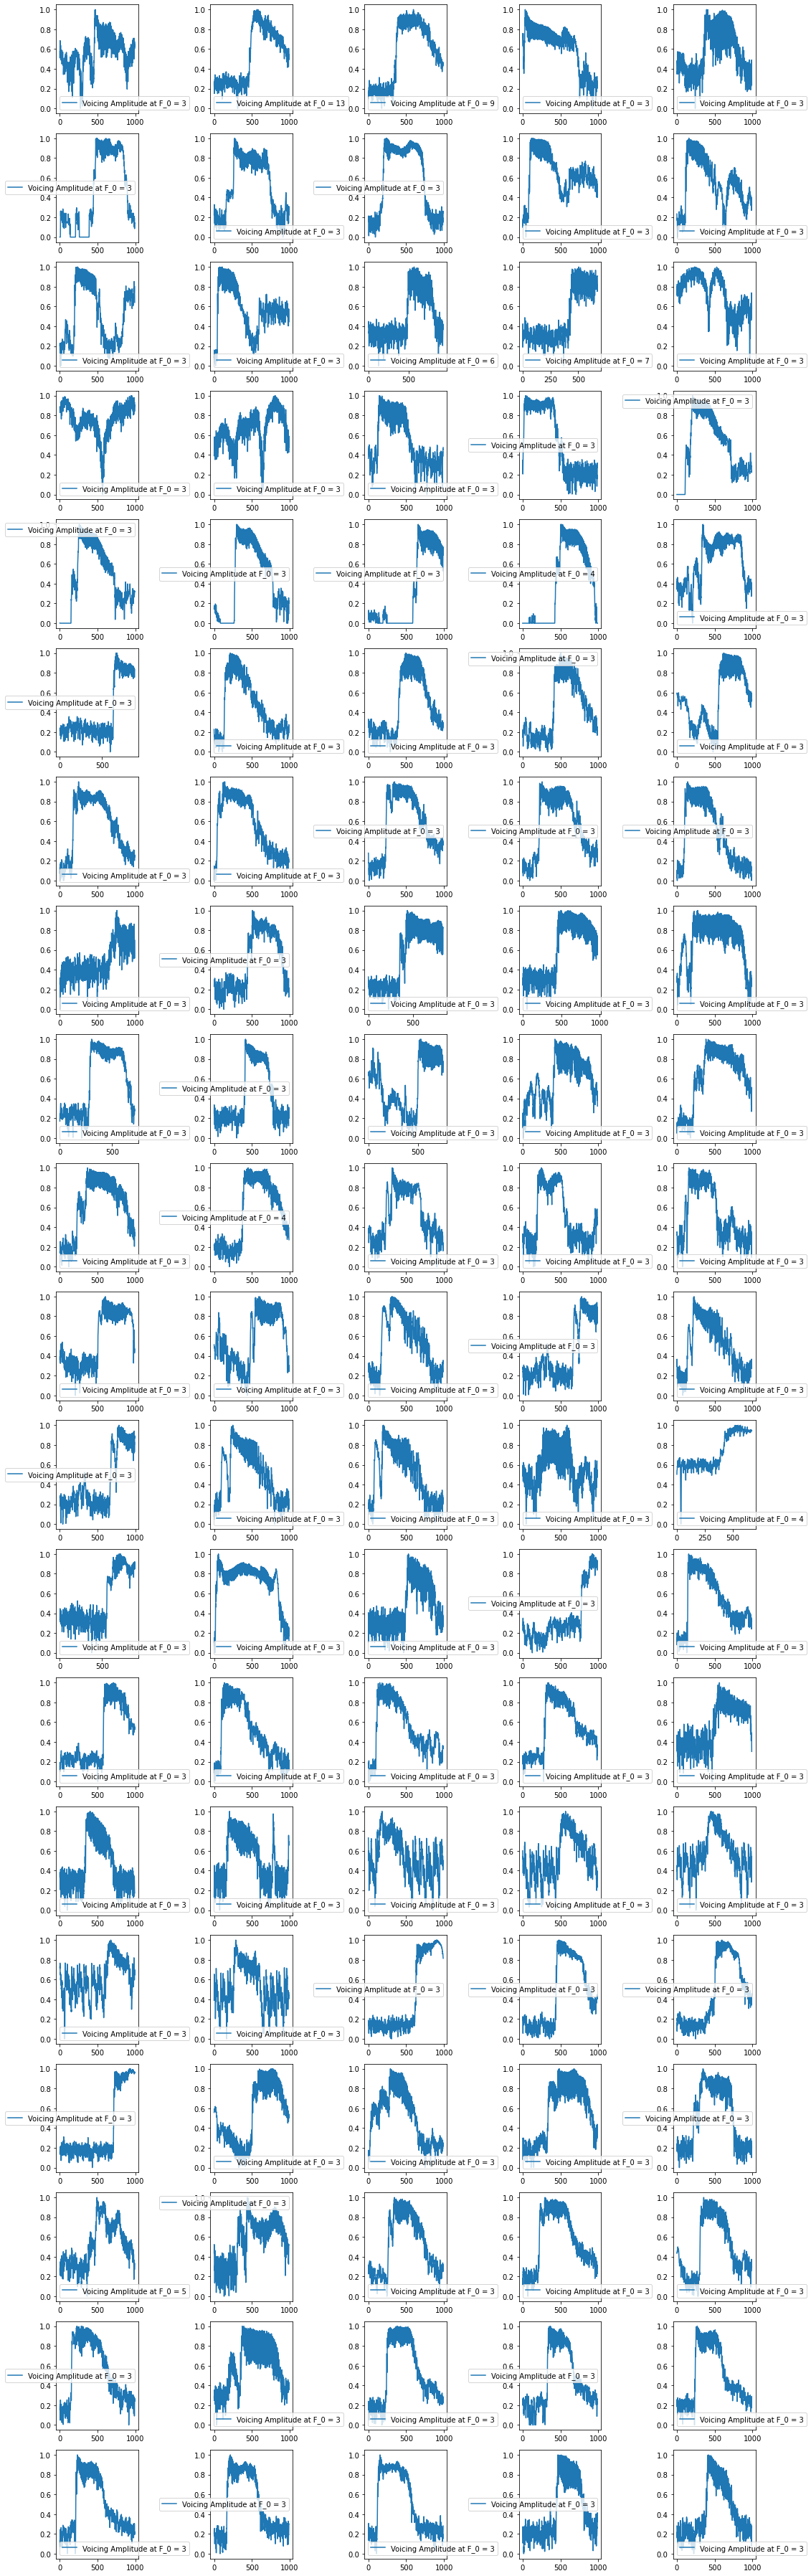

In [19]:
nrows=20
ncols=5
figure, ax = plt.subplots(nrows, ncols, figsize=(15,50))

for i in range(nrows):
    for j in range(ncols):
        new_spectrogram, log_new_spectrogram = get_spectrogram(text_samples[i*ncols + j])
        voicing_amplitude = get_plot_voicing(new_spectrogram, ax[i,j])

figure.tight_layout()

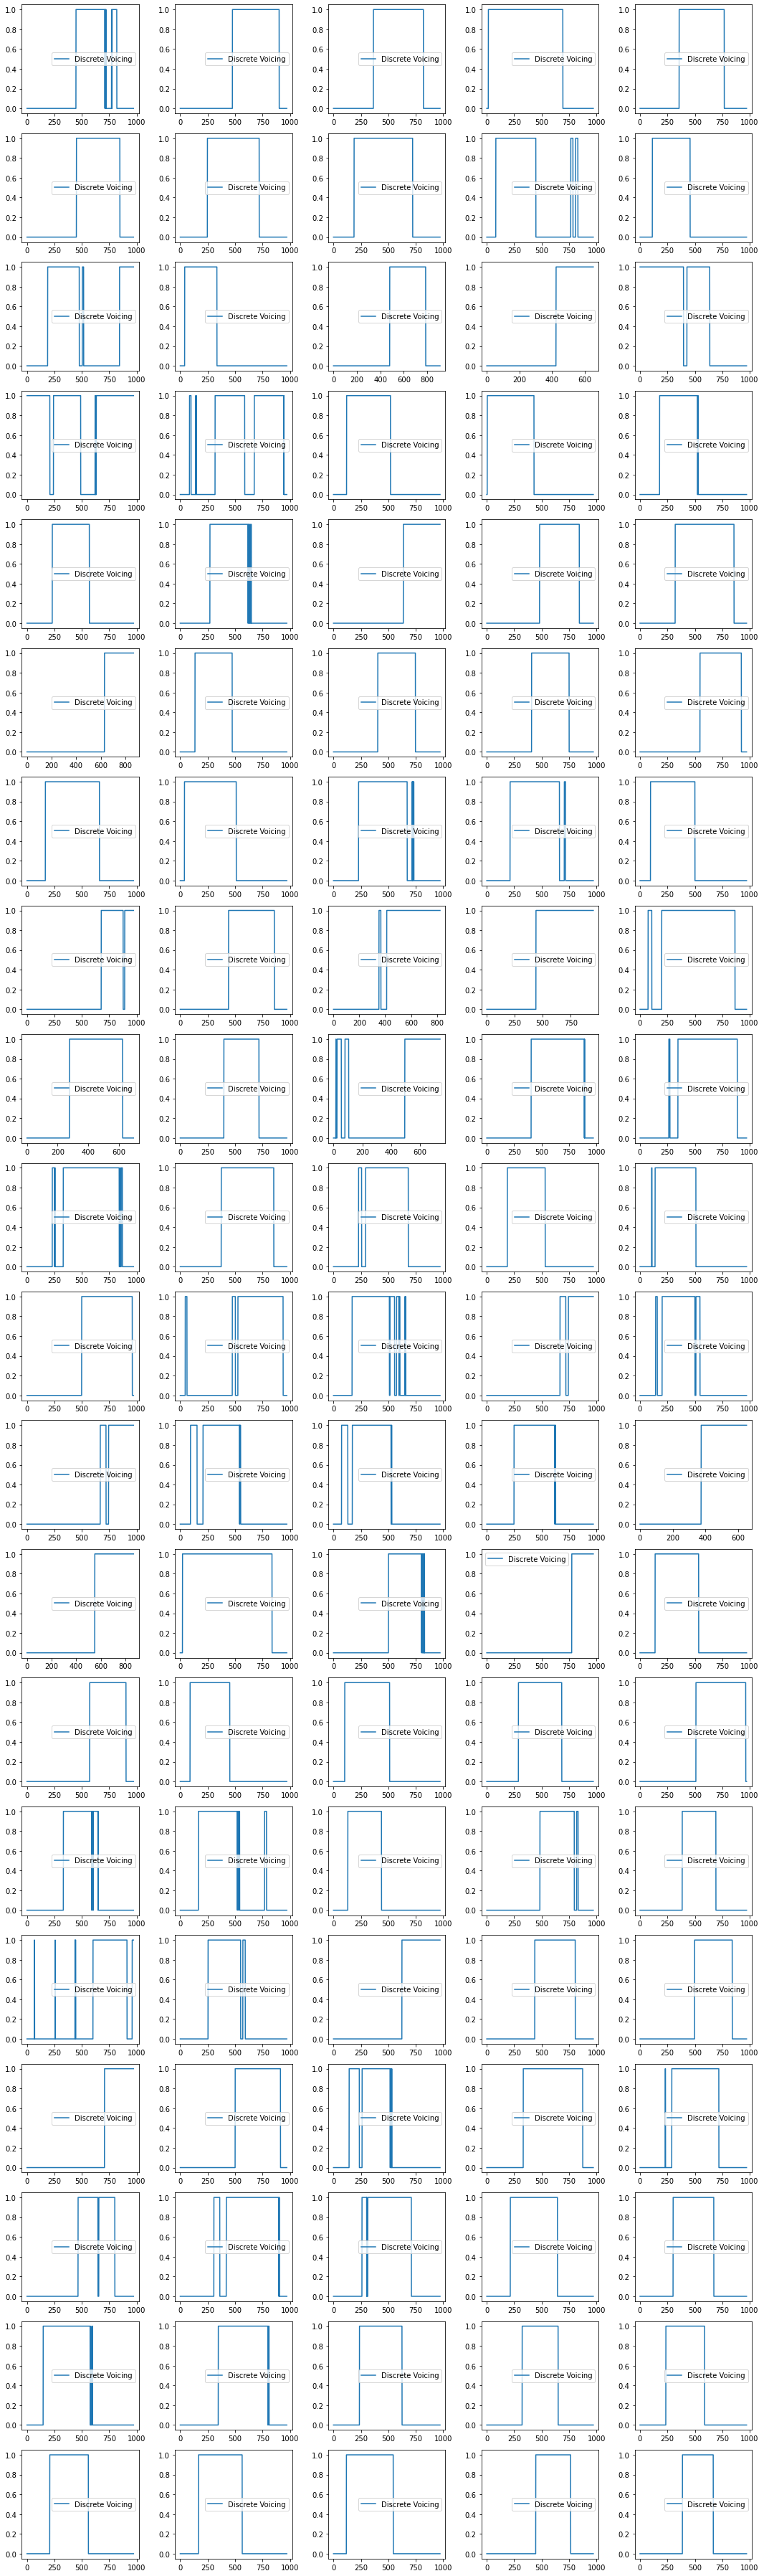

In [27]:
nrows=20
ncols=5
figure, ax = plt.subplots(nrows, ncols, figsize=(15,50))

for i in range(nrows):
    for j in range(ncols):
        new_spectrogram, log_new_spectrogram = get_spectrogram(text_samples[i*ncols + j])
        voicing_amplitude = get_plot_voicing(new_spectrogram, ax[i,j], plot=False)
        smooth_voicing_amplitude = smooth_plot_voicing(voicing_amplitude, 20, ax[i,j], plot=False)
        discrete_voicing = discretize_plot_voicing(smooth_voicing_amplitude, 0.65, ax[i,j], plot=True)

figure.tight_layout()

## TODO
- Make obtaining spectrograms computationally faster, then plot the voicing and amplitudes for different words for exploration.
    - Might want to get 6KHz images, and tune the frequency ranges.
- Looks like to detect [s], we specifically want to check the difference between in range and out range amplitude, where in range should be bigger. Might need to increase frequencies to 6KHz to see a more clear [s] amplitude difference.
- Detecting [n] might also come from seeing when the bottom range amplitude is greater than top range amplitude, since [n] mostly occupies very low frequencies!

# Plan
- Make obtaining spectrograms faster so we can get batches of them (DONE)
- Mask the formant features
    - Tried slope of voicing_amplitude, but that doesn't look helpful. Will try to threshold at 0.6, set everything above to 1, everything below to 0, then multiply with formants
    - To do this, will need to find the biggest range of 1s
- Analyze resulting formant features, and see what operations to do with them to distinguish them best